<a href="https://www.kaggle.com/code/aryandec25/notebook-stackoverflow?scriptVersionId=136798365" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Importing all the required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
import warnings
warnings.filterwarnings('ignore')


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer

import nltk
nltk.download('wordnet')
! unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/
from nltk.stem import WordNetLemmatizer

import re
from wordcloud import WordCloud
from bs4 import BeautifulSoup

from sklearn.model_selection import cross_val_score


from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score,accuracy_score,classification_report

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/co

In [3]:
!unzip /kaggle/input/facebook-recruiting-iii-keyword-extraction/Train.zip

Archive:  /kaggle/input/facebook-recruiting-iii-keyword-extraction/Train.zip
  inflating: Train.csv               


In [4]:
df_train = pd.read_csv('/kaggle/working/Train.csv').sample(500000)

# Exploring the data

In [5]:
print(f'The shape of the Train dataset: {df_train.shape}')

The shape of the Train dataset: (500000, 4)


In [6]:
df_train.reset_index(drop = True,inplace=True)

In [7]:
df_train.head()

,Id,Title,Body,Tags
0,1031284,Is there some standard way to publish a calend...,"<p>For a web application I am working on, I wo...",calendar feed
1,178489,How do I create an Editor Option in the new VS...,"<p>The <a href=""http://msdn.microsoft.com/en-u...",visual-studio visual-studio-2010 mef
2,5782327,Deserialize List Error,<p>I have an XML and the content is</p>\n\n<pr...,c# xml exception-handling xml-serialization de...
3,867061,is dispatcher a individual process or it just ...,"<p>hello\nin unix BSD 5 operating system,do we...",c++ c linux operating-system linux-kernel
4,1139154,How should I add a forum to my site?,<p>I started an Octopress blog and I'd like to...,ruby-on-rails octopress


In [8]:
df_train['Body'][0]

'<p>For a web application I am working on, I would like to be able to give the user a single url that they can enter into the calendar application of their choosing to have events from our application show up in their calendar.</p>\n\n<p>Most other sites I have seen that do similar things will have a one time download of an .ics file that can be imported. If I have to require my users to download a new file every time the schedule changes, it sort of defeats the purpose of having the feed at all. The calendar can change many many times a day. </p>\n\n<p>What I would really like is something like rss where their calendar program can look up a url and automatically see the most recent data. Does anything like this exist? Our main target is mobile devices, so it really should be supported by iCal and google Calendar. Anything else is bonus.</p>\n'

In [9]:
df_train['Tags'][0]

'calendar feed'

In [10]:
print(f'Train DataFrame Shape: {df_train.shape}')

Train DataFrame Shape: (500000, 4)


## Data pre-processing

### Checking for duplicates

In [11]:
duplicated_pairs = df_train.sort_values('Title', ascending=False).duplicated('Title')
print(f'Total number of duplicated questions: {duplicated_pairs.sum()}')

df_train = df_train[~duplicated_pairs]
print(f'Dataframe shape after duplicate removal: {df_train.shape}')


Total number of duplicated questions: 14954
Dataframe shape after duplicate removal: (485046, 4)


In [12]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 485046 entries, 0 to 499999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Id      485046 non-null  int64 
 1   Title   485046 non-null  object
 2   Body    485046 non-null  object
 3   Tags    485046 non-null  object
dtypes: int64(1), object(3)
memory usage: 18.5+ MB


In [13]:
df_train.isnull().sum()

Id       0
Title    0
Body     0
Tags     0
dtype: int64

In [14]:
df_train.dropna(axis=0, inplace=True)

In [15]:
df_train.isnull().sum()

Id       0
Title    0
Body     0
Tags     0
dtype: int64

In [16]:
from pprint import pprint

pprint(df_train.iloc[3].to_dict(), compact=True)

{'Body': '<p>hello\n'
         'in unix BSD 5 operating system,do we have dispatcher a separate '
         'process with process id or its code is executed with context of some '
         'other process.\n'
         'for example if we have some user running program which needs to be '
         'dispatched back to "ready to run in memory"...so dispatcher would '
         'runs in user program context or not?\n'
         'any help would be appreciated. </p>\n',
 'Id': 867061,
 'Tags': 'c++ c linux operating-system linux-kernel',
 'Title': 'is dispatcher a individual process or it just runs in context of '
          'some other process'}


#### Creating a tag count column as a new feature

In [18]:
df_train['Tag_Counts'] = df_train['Tags'].apply(lambda x: len(x.split()))

In [19]:
df_train[['Tags','Tag_Counts']]

,Tags,Tag_Counts
0,calendar feed,2
1,visual-studio visual-studio-2010 mef,3
2,c# xml exception-handling xml-serialization de...,5
3,c++ c linux operating-system linux-kernel,5
4,ruby-on-rails octopress,2
...,...,...
499995,javascript file-upload request firefox-addon-sdk,4
499996,asp.net-mvc-3,1
499997,.htaccess url redirect,3
499998,php hash encode,3


## Basic Data Analysis on Tags

### Frequency of tag_count

In [20]:
df_train['Tag_Counts'].value_counts()

3    139183
2    129058
4     93176
1     66831
5     56798
Name: Tag_Counts, dtype: int64

In [21]:
print( "Maximum number of tags in a question: ", df_train["Tag_Counts"].max())
print( "Minimum number of tags in a question: ", df_train["Tag_Counts"].min())
print( "Average number of tags in a question: ", df_train["Tag_Counts"].mean())

Maximum number of tags in a question:  5
Minimum number of tags in a question:  1
Average number of tags in a question:  2.8846542389793957


In [22]:
df_train

,Id,Title,Body,Tags,Tag_Counts
0,1031284,Is there some standard way to publish a calend...,"<p>For a web application I am working on, I wo...",calendar feed,2
1,178489,How do I create an Editor Option in the new VS...,"<p>The <a href=""http://msdn.microsoft.com/en-u...",visual-studio visual-studio-2010 mef,3
2,5782327,Deserialize List Error,<p>I have an XML and the content is</p>\n\n<pr...,c# xml exception-handling xml-serialization de...,5
3,867061,is dispatcher a individual process or it just ...,"<p>hello\nin unix BSD 5 operating system,do we...",c++ c linux operating-system linux-kernel,5
4,1139154,How should I add a forum to my site?,<p>I started an Octopress blog and I'd like to...,ruby-on-rails octopress,2
...,...,...,...,...,...
499995,2734946,Upload an image file using the request object,<p>In the Firefox extension I am currently dev...,javascript file-upload request firefox-addon-sdk,4
499996,3266524,How to Post Partial View Data,<p>Any input much appriciated :)</p>\n\n<p>I w...,asp.net-mvc-3,1
499997,2443544,.htaccess 301 redirect friendly url,<p>I'm trying to do a 301 redirect.</p>\n\n<p>...,.htaccess url redirect,3
499998,294031,"Creating collision free ""random"" string",<p>I have been writing some software that uses...,php hash encode,3


Something looks odd about this

In [23]:
df_train['Tag_Counts'].value_counts()

3    139183
2    129058
4     93176
1     66831
5     56798
Name: Tag_Counts, dtype: int64

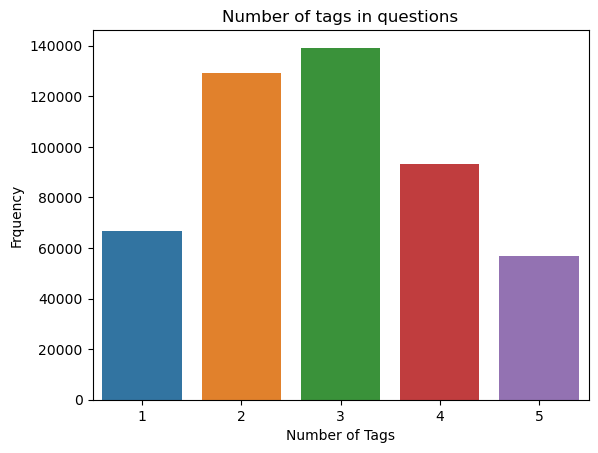

In [24]:
df_train_tag_freq = df_train['Tag_Counts'].value_counts().reset_index().sort_values(by='index').rename(columns = {'index':'tag_count', 'Tag_Counts':'tag_value_counts'})


plt.title('Number of tags in questions')
sns.barplot(data = df_train_tag_freq, x = 'tag_count', y = 'tag_value_counts')
plt.xlabel('Number of Tags')
plt.ylabel('Frquency')
plt.show()

#### Observations: 
1. Maximum number of tags in question: 5
2. Minimum number of tags in question: 1
3. Average number of tags in question: 2.89
4. Most of the questions have either 2 or 3 tags to work with.

### Total number of unique Tags

In [25]:
vectorizer = CountVectorizer(tokenizer = lambda x : x.split())
tag_bow = vectorizer.fit_transform(df_train['Tags'])

In [26]:
tag_bow.shape

(485046, 30332)

In [27]:
print("Number of questions :", tag_bow.shape[0])
print("Number of unique tags :", tag_bow.shape[1])

Number of questions : 485046
Number of unique tags : 30332


In [28]:
tags = vectorizer.get_feature_names_out()
print("Few tags :", tags[:10])

Few tags : ['.a' '.app' '.aspxauth' '.bash-profile' '.class-file' '.cs-file' '.doc'
 '.ds-store' '.each' '.emf']


In [29]:
df_train.head()

,Id,Title,Body,Tags,Tag_Counts
0,1031284,Is there some standard way to publish a calend...,"<p>For a web application I am working on, I wo...",calendar feed,2
1,178489,How do I create an Editor Option in the new VS...,"<p>The <a href=""http://msdn.microsoft.com/en-u...",visual-studio visual-studio-2010 mef,3
2,5782327,Deserialize List Error,<p>I have an XML and the content is</p>\n\n<pr...,c# xml exception-handling xml-serialization de...,5
3,867061,is dispatcher a individual process or it just ...,"<p>hello\nin unix BSD 5 operating system,do we...",c++ c linux operating-system linux-kernel,5
4,1139154,How should I add a forum to my site?,<p>I started an Octopress blog and I'd like to...,ruby-on-rails octopress,2


### Frequency of each tag

In [30]:
freq = tag_bow.sum(axis = 0).A1
tag_to_count_map = dict(zip(tags,freq))

In [31]:
freq

array([3, 6, 1, ..., 1, 4, 1])

In [32]:
print(f'Shape of Freqeuency: {freq.shape}')
print(f'Shape of Tags: {tags.shape}')

Shape of Freqeuency: (30332,)
Shape of Tags: (30332,)


In [33]:
list = []
for key, value in tag_to_count_map.items():
    list.append([key, value]) 


tag_df_train = pd.DataFrame(list, columns=['Tags', 'Counts'])
tag_df_train.head()

,Tags,Counts
0,.a,3
1,.app,6
2,.aspxauth,1
3,.bash-profile,15
4,.class-file,8


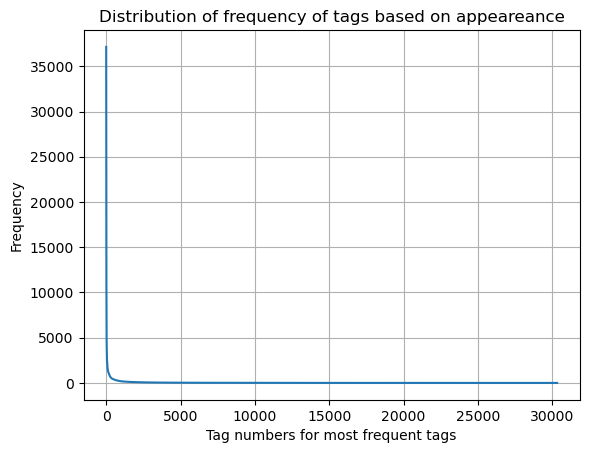

In [34]:
tag_df_train_sorted = tag_df_train.sort_values(['Counts'], ascending=False)
plt.plot(tag_df_train_sorted['Counts'].values)
plt.grid()
plt.title("Distribution of frequency of tags based on appeareance")
plt.xlabel("Tag numbers for most frequent tags")
plt.ylabel("Frequency")
plt.show()

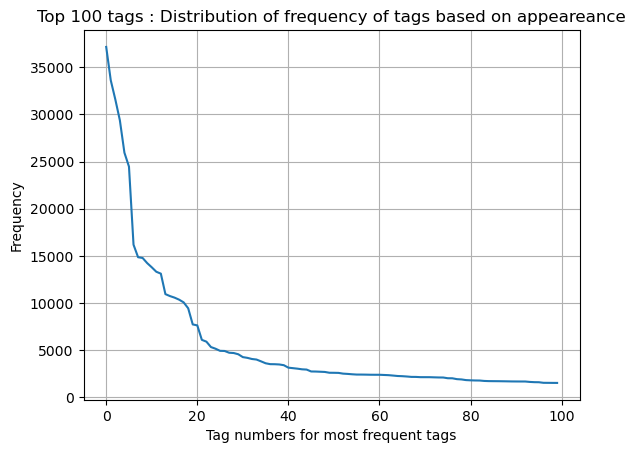

In [35]:
plt.plot(tag_df_train_sorted['Counts'][0:100].values)
plt.grid()
plt.title("Top 100 tags : Distribution of frequency of tags based on appeareance")
plt.xlabel("Tag numbers for most frequent tags")
plt.ylabel("Frequency")
plt.show()

In [36]:
tag_bow

<485046x30332 sparse matrix of type '<class 'numpy.int64'>'
	with 1399190 stored elements in Compressed Sparse Row format>

Data pre-processing

- Cleaning up the title and body
- realtion with name of the tag and title or body
- Present of code snippet based on body. 
- Length of the body
- if any attachment  with the questions. 
- Url attachments
- Synonymn of tags in title or body.


In [37]:
df_train

,Id,Title,Body,Tags,Tag_Counts
0,1031284,Is there some standard way to publish a calend...,"<p>For a web application I am working on, I wo...",calendar feed,2
1,178489,How do I create an Editor Option in the new VS...,"<p>The <a href=""http://msdn.microsoft.com/en-u...",visual-studio visual-studio-2010 mef,3
2,5782327,Deserialize List Error,<p>I have an XML and the content is</p>\n\n<pr...,c# xml exception-handling xml-serialization de...,5
3,867061,is dispatcher a individual process or it just ...,"<p>hello\nin unix BSD 5 operating system,do we...",c++ c linux operating-system linux-kernel,5
4,1139154,How should I add a forum to my site?,<p>I started an Octopress blog and I'd like to...,ruby-on-rails octopress,2
...,...,...,...,...,...
499995,2734946,Upload an image file using the request object,<p>In the Firefox extension I am currently dev...,javascript file-upload request firefox-addon-sdk,4
499996,3266524,How to Post Partial View Data,<p>Any input much appriciated :)</p>\n\n<p>I w...,asp.net-mvc-3,1
499997,2443544,.htaccess 301 redirect friendly url,<p>I'm trying to do a 301 redirect.</p>\n\n<p>...,.htaccess url redirect,3
499998,294031,"Creating collision free ""random"" string",<p>I have been writing some software that uses...,php hash encode,3


In [38]:
df_train['Body'][1]

'<p>The <a href="http://msdn.microsoft.com/en-us/library/dd885244%28VS.100%29.aspx" rel="nofollow">list of extensibility points</a> for the VS2010 Editor mentios creating EditorOptionDefinitions along with a small sample. When I attempt to do this I cannot find the options anywhere in the VS2010 UI. How do I create these so that they are surfaced in the UI?</p>\n'

In [39]:
tag_df_train_sorted

,Tags,Counts
3179,c#,37143
13081,java,33611
19664,php,31582
13152,javascript,29368
886,android,25936
...,...,...
22843,sarissa,1
10146,gethostbyaddr,1
10137,getdistance,1
10136,getdirectories,1


In [40]:
print("{} tags are used more than 25 times".format(tag_df_train_sorted[tag_df_train_sorted["Counts"]>25].shape[0]))
print("{} tags are used more than 50 times".format(tag_df_train_sorted[tag_df_train_sorted["Counts"]>50].shape[0]))

4977 tags are used more than 25 times
3070 tags are used more than 50 times


### Observations:
1. 144 tags are used more than 25 times.
2. 59 tags are used more than 50 times.
3. C# is most frequently used tag 778 times.
4. Since some tags occur much more frequenctly than others, Micro-averaged F1-score is the appropriate metric for this probelm.

## Word map

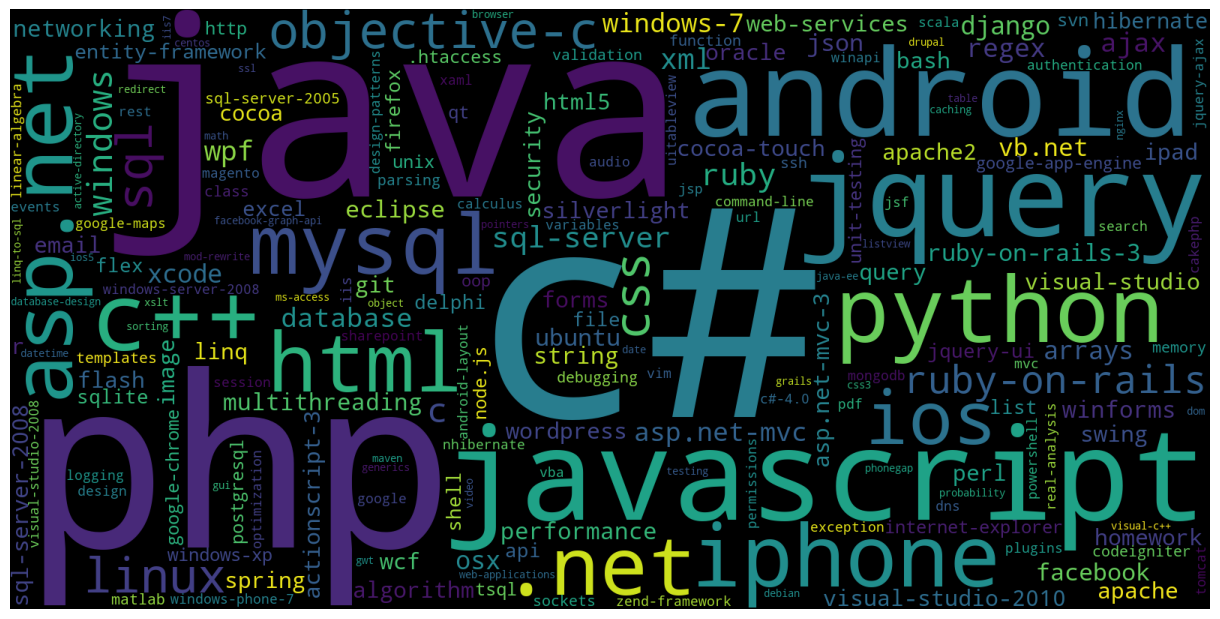

In [41]:
tag_to_count_map
tupl = dict(tag_to_count_map.items())
word_cloud = WordCloud(width=1600,height=800,).generate_from_frequencies(tupl)
plt.figure(figsize = (12,8))
plt.imshow(word_cloud)
plt.axis('off')
plt.tight_layout(pad=0)

### Barplot of top 20 tags

In [42]:
tag_df_train_sorted.reset_index(drop=True)

,Tags,Counts
0,c#,37143
1,java,33611
2,php,31582
3,javascript,29368
4,android,25936
...,...,...
30327,sarissa,1
30328,gethostbyaddr,1
30329,getdistance,1
30330,getdirectories,1


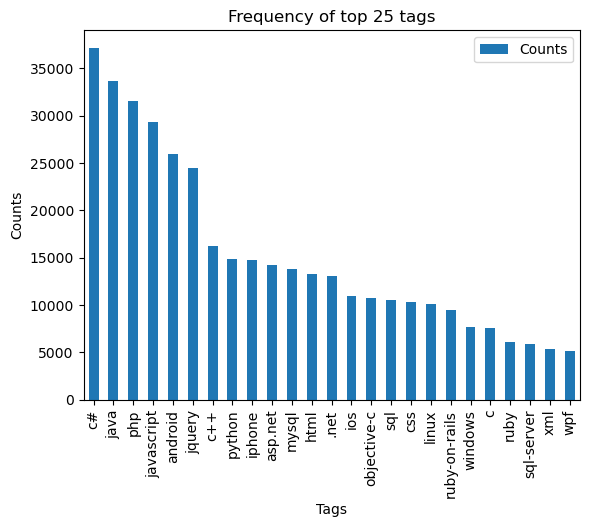

In [43]:
i=np.arange(25)
tag_df_train_sorted.head(25).plot(kind='bar')
plt.title('Frequency of top 25 tags')
plt.xticks(i, tag_df_train_sorted['Tags'].head(25))
plt.xlabel('Tags')
plt.ylabel('Counts')
plt.show()

In [44]:
print("{} tags are used more than 25 times".format(tag_df_train_sorted[tag_df_train_sorted["Counts"]>25].shape[0]))
print("{} tags are used more than 50 times".format(tag_df_train_sorted[tag_df_train_sorted["Counts"]>50].shape[0]))

4977 tags are used more than 25 times
3070 tags are used more than 50 times


In [45]:
tag_df_train_sorted['Tags']

3179                 c#
13081              java
19664               php
13152        javascript
886             android
              ...      
22843           sarissa
10146     gethostbyaddr
10137       getdistance
10136    getdirectories
30331           zzt-oop
Name: Tags, Length: 30332, dtype: object

<Axes: xlabel='Body_Length', ylabel='Tag_Counts'>

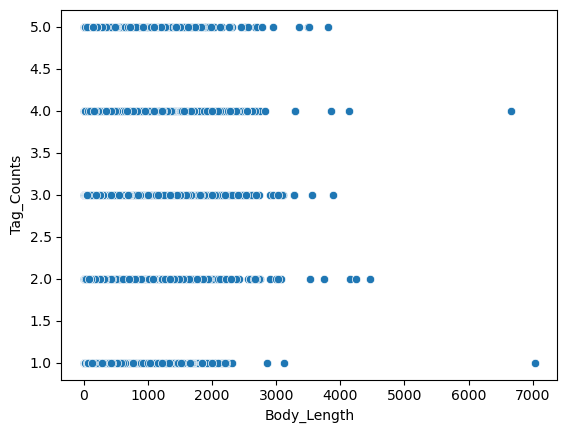

In [46]:
df_train['Body_Length'] = df_train['Body'].apply(lambda x : len(x.split()))
sns.scatterplot(x= df_train['Body_Length'], y = df_train['Tag_Counts'])

<Axes: xlabel='Title_Length', ylabel='Tag_Counts'>

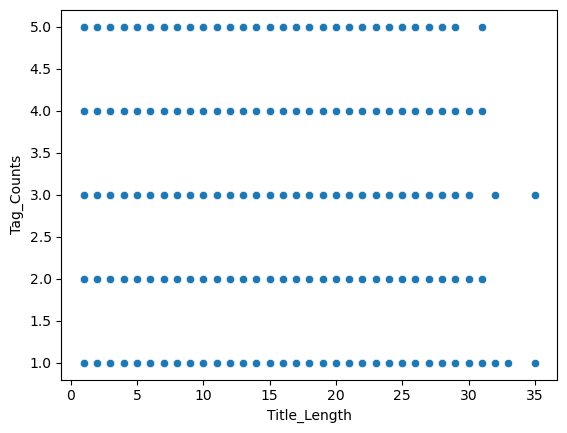

In [47]:
df_train['Title_Length'] = df_train['Title'].apply(lambda x : len(x.split()))
sns.scatterplot(x= df_train['Title_Length'], y = df_train['Tag_Counts'])

## Text preprocessing

In [48]:
def find_code(df):
    if '<code>' in df:
        return 1
    else: 
        return 0

    
df_train['is_code'] = df_train['Body'].apply(find_code)

In [49]:
df_train

,Id,Title,Body,Tags,Tag_Counts,Body_Length,Title_Length,is_code
0,1031284,Is there some standard way to publish a calend...,"<p>For a web application I am working on, I wo...",calendar feed,2,157,10,0
1,178489,How do I create an Editor Option in the new VS...,"<p>The <a href=""http://msdn.microsoft.com/en-u...",visual-studio visual-studio-2010 mef,3,48,13,0
2,5782327,Deserialize List Error,<p>I have an XML and the content is</p>\n\n<pr...,c# xml exception-handling xml-serialization de...,5,123,3,1
3,867061,is dispatcher a individual process or it just ...,"<p>hello\nin unix BSD 5 operating system,do we...",c++ c linux operating-system linux-kernel,5,63,15,0
4,1139154,How should I add a forum to my site?,<p>I started an Octopress blog and I'd like to...,ruby-on-rails octopress,2,119,9,1
...,...,...,...,...,...,...,...,...
499995,2734946,Upload an image file using the request object,<p>In the Firefox extension I am currently dev...,javascript file-upload request firefox-addon-sdk,4,163,8,1
499996,3266524,How to Post Partial View Data,<p>Any input much appriciated :)</p>\n\n<p>I w...,asp.net-mvc-3,1,119,6,1
499997,2443544,.htaccess 301 redirect friendly url,<p>I'm trying to do a 301 redirect.</p>\n\n<p>...,.htaccess url redirect,3,44,5,1
499998,294031,"Creating collision free ""random"" string",<p>I have been writing some software that uses...,php hash encode,3,186,5,0


In [50]:
print(f"There are a total of {df_train[df_train['is_code'] == 1].shape[0]} questions with code out of {df_train.shape[0]}")
print(f"{np.round((100 * df_train[df_train['is_code'] == 1].shape[0])/df_train.shape[0],2)}% of the questions has code")

There are a total of 273065 questions with code out of 485046
56.3% of the questions has code


In [51]:
df_train

,Id,Title,Body,Tags,Tag_Counts,Body_Length,Title_Length,is_code
0,1031284,Is there some standard way to publish a calend...,"<p>For a web application I am working on, I wo...",calendar feed,2,157,10,0
1,178489,How do I create an Editor Option in the new VS...,"<p>The <a href=""http://msdn.microsoft.com/en-u...",visual-studio visual-studio-2010 mef,3,48,13,0
2,5782327,Deserialize List Error,<p>I have an XML and the content is</p>\n\n<pr...,c# xml exception-handling xml-serialization de...,5,123,3,1
3,867061,is dispatcher a individual process or it just ...,"<p>hello\nin unix BSD 5 operating system,do we...",c++ c linux operating-system linux-kernel,5,63,15,0
4,1139154,How should I add a forum to my site?,<p>I started an Octopress blog and I'd like to...,ruby-on-rails octopress,2,119,9,1
...,...,...,...,...,...,...,...,...
499995,2734946,Upload an image file using the request object,<p>In the Firefox extension I am currently dev...,javascript file-upload request firefox-addon-sdk,4,163,8,1
499996,3266524,How to Post Partial View Data,<p>Any input much appriciated :)</p>\n\n<p>I w...,asp.net-mvc-3,1,119,6,1
499997,2443544,.htaccess 301 redirect friendly url,<p>I'm trying to do a 301 redirect.</p>\n\n<p>...,.htaccess url redirect,3,44,5,1
499998,294031,"Creating collision free ""random"" string",<p>I have been writing some software that uses...,php hash encode,3,186,5,0


In [52]:
df_train[df_train['is_code'] == 1]['Body'].reset_index().iloc[4,:]['Body']

'<p>I have a list of items sorted by the date, I want the date to remain fixed on the side as the user scrolls past the elements so that the user always knows the dates of the elements. </p>\n\n<p>My html looks something like this:</p>\n\n<pre><code>&lt;div class="event_date"&gt;Jan 1, 2012&lt;/div&gt;\n&lt;div&gt; stuff here &lt;/div&gt;\n&lt;div&gt; stuff here &lt;/div&gt;\n&lt;div class="event_date"&gt;Jan 2, 2012&lt;/div&gt;\n&lt;div&gt; stuff here &lt;/div&gt;\n&lt;div&gt; stuff here &lt;/div&gt;\n&lt;div class="event_date"&gt;Jan 3, 2012&lt;/div&gt;\n&lt;div&gt; stuff here &lt;/div&gt;\n...\n</code></pre>\n\n<p>I already have a fixed div box that doesn\'t move when the user scrolls on the page </p>\n\n<pre><code>&lt;div id="current_date_box"&gt;&lt;/div&gt;\n</code></pre>\n\n<p>My current javascript looks like this:</p>\n\n<pre><code>$(window).scroll(function(){\n    if ($(".event_date").offset().top &lt; $(window).scrollTop()) {\n        //the code only affects the first element

In [53]:
pprint(df_train[df_train['is_code'] == 1].iloc[1].to_dict(), compact=True)

{'Body': "<p>I started an Octopress blog and I'd like to add a forum to the "
         "site as well. I'm guessing that I should create a subdomain like "
         '<code>www.blog.example.net</code>. Or is there a smarter way to do '
         'this? </p>\n'
         '\n'
         '<p>At first I was thinking of using some of my Rails knowledge to '
         'splice in forum code but that seems like a really bad hack that '
         'would probably destroy my Octopress installation. </p>\n'
         '\n'
         "<p>As far as subdomains are concerned, I'm not too experienced, "
         'Would that be a best practice to go ahead and create a subdomain? '
         '</p>\n'
         '\n'
         "<p>If you say that it is I'll do my research on understanding sub "
         'domains and go that route. Are there any other options for me?</p>\n',
 'Body_Length': 119,
 'Id': 1139154,
 'Tag_Counts': 2,
 'Tags': 'ruby-on-rails octopress',
 'Title': 'How should I add a forum to my site?',
 'Titl

In [54]:
def striphtml(data):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr,' ',str(data))
    return cleantext



stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer('english')
lemmatizer = WordNetLemmatizer()

In [55]:
# Top 20 tags used in our corpus
list_tags = tag_df_train_sorted['Tags'].head(20).to_list()

# Filtering by only those rows where the tags are in top 20
df_tags = df_train[(df_train['Tags'].isin(list_tags))][['Title','Body', 'Tags']]

df_tags.head(2)

,Title,Body,Tags
20,static_cast in default argument value,<p>I would like to have a constructor with def...,c++
21,Does array_shift and explode work?,<p>I wonder if they disabled <code>array_shift...,php


In [56]:
df_train

,Id,Title,Body,Tags,Tag_Counts,Body_Length,Title_Length,is_code
0,1031284,Is there some standard way to publish a calend...,"<p>For a web application I am working on, I wo...",calendar feed,2,157,10,0
1,178489,How do I create an Editor Option in the new VS...,"<p>The <a href=""http://msdn.microsoft.com/en-u...",visual-studio visual-studio-2010 mef,3,48,13,0
2,5782327,Deserialize List Error,<p>I have an XML and the content is</p>\n\n<pr...,c# xml exception-handling xml-serialization de...,5,123,3,1
3,867061,is dispatcher a individual process or it just ...,"<p>hello\nin unix BSD 5 operating system,do we...",c++ c linux operating-system linux-kernel,5,63,15,0
4,1139154,How should I add a forum to my site?,<p>I started an Octopress blog and I'd like to...,ruby-on-rails octopress,2,119,9,1
...,...,...,...,...,...,...,...,...
499995,2734946,Upload an image file using the request object,<p>In the Firefox extension I am currently dev...,javascript file-upload request firefox-addon-sdk,4,163,8,1
499996,3266524,How to Post Partial View Data,<p>Any input much appriciated :)</p>\n\n<p>I w...,asp.net-mvc-3,1,119,6,1
499997,2443544,.htaccess 301 redirect friendly url,<p>I'm trying to do a 301 redirect.</p>\n\n<p>...,.htaccess url redirect,3,44,5,1
499998,294031,"Creating collision free ""random"" string",<p>I have been writing some software that uses...,php hash encode,3,186,5,0


Note: Based on the currect logic 

In [57]:
df_train[(df_train['Tags'].isin(list_tags))][['Title','Body', 'Tags']]

,Title,Body,Tags
20,static_cast in default argument value,<p>I would like to have a constructor with def...,c++
21,Does array_shift and explode work?,<p>I wonder if they disabled <code>array_shift...,php
44,Is one of these syntaxes works faster or both ...,"<p>I heard, that second syntax is much faster....",jquery
46,ArrayAdapter - What am I doing wrong?,<p>I have a ListActivity that I'm trying to bi...,android
47,Is it possible for data to change after updati...,<p>I updated mysql through apt-get. shortly af...,mysql
...,...,...,...
499841,"Iphone-SDK ""unable to read symbols error"" when...",<p>I built a very simple tab based app with 2 ...,iphone
499909,How to take diff of two directories and apply ...,<p>I am newbie to using diff. I wish to creat...,linux
499917,Why does the else branch not get executed?,<p>This actually is a working application. Alb...,c#
499921,trying to write a proper if statement in php,<p>i am having a hard time wrapping my head ar...,php


In [58]:
df_tags.shape

(23647, 3)

In [60]:
# df_tags[df_tags['Title'] == 'Why is my cube only rendering as a square?']

In [61]:
df_tags['Tags'].unique()

array(['c++', 'php', 'jquery', 'android', 'mysql', '.net', 'java', 'c#',
       'asp.net', 'sql', 'ios', 'iphone', 'ruby-on-rails', 'css',
       'javascript', 'python', 'objective-c', 'windows', 'html', 'linux'],
      dtype=object)

In [62]:
start = datetime.now()
preprocessed_data_list=[]
questions_with_code=0
len_pre=0
len_post=0
questions_proccesed = 0
prepared_df = pd.DataFrame(columns=['question','code','tags','words_pre','words_post','is_code'])


for row in df_tags.iterrows():

    is_code = 0

    title, question, tags = row[1][0], row[1][1], row[1][2]

    if '<code>' in question:
        questions_with_code+=1
        is_code = 1
        
    x = len(question)+len(title)
    len_pre+=x

    code = str(re.findall(r'<code>(.*?)</code>', question, flags=re.DOTALL))

    question=re.sub('<code>(.*?)</code>', '', question, flags=re.MULTILINE|re.DOTALL)
    question=striphtml(question.encode('utf-8'))

    title=title.encode('utf-8')

    question=str(title)+" "+str(question)
    question=re.sub(r'[^A-Za-z]+',' ',question)
    words=word_tokenize(str(question.lower()))

    #Removing all single letter and and stopwords from question exceptt for the letter 'c'
    question=' '.join(str(stemmer.stem(j)) for j in words if j not in stop_words and (len(j)!=1 or j=='c'))

    len_post+=len(question)
    processed_di = {
        "question": question,
        "code": code,
        "tags": tags,
        "words_pre": x,
        "words_post": len(question),
        "is_code" : is_code
    }
    
    prepared_df.loc[len(prepared_df.index)] = [question,code,tags,x,len(question),is_code]
    
    questions_proccesed += 1
    if (questions_proccesed%100000==0):
        print("number of questions completed=",questions_proccesed)

no_dup_avg_len_pre=(len_pre*1.0)/questions_proccesed
no_dup_avg_len_post=(len_post*1.0)/questions_proccesed

print( "Avg. length of questions(Title+Body) before processing: %d"%no_dup_avg_len_pre)
print( "Avg. length of questions(Title+Body) after processing: %d"%no_dup_avg_len_post)
print ("Percent of questions containing code: %d"%((questions_with_code*100.0)/questions_proccesed))

print("Time taken to run this cell :", datetime.now() - start)

Avg. length of questions(Title+Body) before processing: 1006
Avg. length of questions(Title+Body) after processing: 240
Percent of questions containing code: 65
Time taken to run this cell : 0:02:25.260581


In [63]:
prepared_df['tags'].value_counts()

android          4040
php              2553
jquery           2237
javascript       1956
java             1864
c#               1808
python           1328
c++              1245
mysql            1216
iphone           1047
asp.net           923
ruby-on-rails     816
css               723
objective-c       402
sql               399
html              285
linux             260
ios               229
.net              170
windows           146
Name: tags, dtype: int64

In [64]:
pprint(df_tags.iloc[1].to_dict(), compact=True)

{'Body': '<p>I wonder if they disabled <code>array_shift</code> in  > PHP '
         '5.2.6</p>\n'
         '\n'
         '<pre><code>$realid = array_shift(explode("-", $id));\n'
         '</code></pre>\n'
         '\n'
         '<p>Because this code was working fine on my server PHP Version '
         '5.2.6, while is not working in another server with higher PHP '
         'version.</p>\n'
         '\n'
         '<p>If so, is there anyway I can do the following:</p>\n'
         '\n'
         '<p>For a URL like this <code>87262-any-thing-here.html</code> how '
         'can I get only the number, <code>87262</code>, so that I will use it '
         'to call any entry from database:</p>\n'
         '\n'
         '<pre><code>$qryrec="select * from mytable where id=\'$realid\'";\n'
         '$resultrec=mysql_query($qryrec) or die($qryrec);\n'
         '$linerec=mysql_fetch_array($resultrec);\n'
         '</code></pre>\n'
         '\n'
         '<p>Is there any way to do the same without 

In [65]:
pprint(prepared_df.iloc[1].to_dict(), compact=True)

{'code': '[\'array_shift\', \'$realid = array_shift(explode("-", $id));\\n\', '
         '\'87262-any-thing-here.html\', \'87262\', \'$qryrec="select * from '
         'mytable where id=\\\'$realid\\\'";\\n$resultrec=mysql_query($qryrec) '
         "or die($qryrec);\\n$linerec=mysql_fetch_array($resultrec);\\n', "
         "'array_shift']",
 'is_code': 1,
 'question': 'array shift explod work wonder disabl php code work fine server '
             'php version work anoth server higher php version anyway follow '
             'url like get number use call entri databas way without',
 'tags': 'php',
 'words_post': 181,
 'words_pre': 784}


In [66]:
print('Original Df length: \t' + str(len(df_train)))
len_df_tags = len(prepared_df)
print('df tags length: \t' + str(len_df_tags))

Original Df length: 	485046
df tags length: 	23647


In [67]:
prepared_df['question'][0]

'static cast default argument valu would like constructor default argument static cast like base class mani function object similar gcc say invalid constructor way achiev behavior'

In [68]:
prepared_df = prepared_df[['question','tags']]

In [69]:
i = 0
for items in prepared_df['question']:
    print(items)
    print('------------------------------------------------------------------------------')
    
    i += 1
    
    if i > 10:
        break

static cast default argument valu would like constructor default argument static cast like base class mani function object similar gcc say invalid constructor way achiev behavior
------------------------------------------------------------------------------
array shift explod work wonder disabl php code work fine server php version work anoth server higher php version anyway follow url like get number use call entri databas way without
------------------------------------------------------------------------------
one syntax work faster equal heard second syntax much faster right take equal time edit nok downvot let see test thank alienwebguy anybodi explain
------------------------------------------------------------------------------
arrayadapt wrong listact tri bind array busi object use custom arrayadapt run applic either emul real android devic get null refer arrayadapt line holder txtteam settext info team debug look like call inflat layout actual creat child textview creat outter

## ML Modeling

### Splitting the data for Train Test Split

In [70]:
X = prepared_df.question
y = prepared_df.tags

In [71]:
X.shape

(23647,)

In [72]:
y.shape

(23647,)

In [75]:
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(), binary=True)
y_multilabel = vectorizer.fit_transform(prepared_df['tags'])

In [77]:
y_multilabel.shape

(23647, 20)

In [78]:
X_train, X_test, y_train, y_test = train_test_split(prepared_df.question, y_multilabel, test_size = 0.2,random_state = 42)

print("Number of data points in training data :", X_train.shape[0])
print("Number of data points in test data :", X_test.shape[0])

Number of data points in training data : 18917
Number of data points in test data : 4730


In [79]:
X_train.shape

(18917,)

In [80]:
y_train.shape

(18917, 20)

### Featurization of Training Data

In [136]:
def text_splitter(text):
    return text.split()

tfidf = TfidfVectorizer(min_df=0.00009, max_features=200000, tokenizer = lambda x : x.split(), ngram_range=(1,4))


X_train_multilabel = tfidf.fit_transform(X_train)
X_test_multilabel = tfidf.transform(X_test)

In [121]:
print("Training data shape X : ",X_train_multilabel.shape, "Y :",y_train.shape)
print("Test data shape X : ",X_test_multilabel.shape,"Y:",y_test.shape)

Training data shape X :  (18917, 120826) Y : (18917, 20)
Test data shape X :  (4730, 120826) Y: (4730, 20)


In [122]:
X_train.reset_index().iloc[0,:]['question']

'better case macro inlin function possibl duplic inlin function vs preprocessor macro concept inlin function differ macro honest ask one faster seen much ask one better would grant knowledg yes knowledg hunter'

### 0. SGD Classifier using OVR

In [123]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier

clf = OneVsRestClassifier(SGDClassifier(loss='log_loss', alpha=0.00001, penalty='l2'))
clf.fit(X_train_multilabel, y_train)

OneVsRestClassifier(estimator=SGDClassifier(alpha=1e-05, loss='log_loss'))

In [124]:
%%time
y_pred = clf.predict(X_test_multilabel)

sgd_ovr_accuracy = accuracy_score(y_pred, y_test)
sgd_ovr_macro_f1_score = metrics.f1_score(y_pred, y_test, average = 'macro')
print(f'SGD OVR accuracy {sgd_ovr_accuracy}')
print(f'SGD OVR Macro F1 Score: {sgd_ovr_macro_f1_score}')

print(classification_report(y_test, y_pred,target_names=list_tags))

SGD OVR accuracy 0.6169133192389006
SGD OVR Macro F1 Score: 0.605290048786276
               precision    recall  f1-score   support

           c#       1.00      0.08      0.15        38
         java       0.97      0.84      0.90       830
          php       0.88      0.52      0.65       191
   javascript       0.73      0.28      0.41       347
      android       0.88      0.44      0.59       261
       jquery       0.90      0.71      0.80       164
          c++       0.91      0.17      0.28        60
       python       1.00      0.22      0.36        37
       iphone       0.86      0.54      0.66       208
      asp.net       0.93      0.60      0.73       368
        mysql       0.94      0.61      0.74       369
         html       0.94      0.79      0.86       461
         .net       0.93      0.25      0.40        51
          ios       0.90      0.80      0.85       246
  objective-c       0.83      0.30      0.44        79
          sql       0.91      0.74      0

### 1. Naive Bayes Classifier using OVR

In [125]:
from sklearn.naive_bayes import MultinomialNB,BernoulliNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer,TfidfVectorizer
from sklearn.svm import LinearSVC


nb = OneVsRestClassifier(BernoulliNB())
nb.fit(X_train_multilabel, y_train)

OneVsRestClassifier(estimator=BernoulliNB())

In [126]:
%%time
y_pred = nb.predict(X_test_multilabel)

nb_ovr_accuracy = accuracy_score(y_pred, y_test)
nb_ovr_macro_f1_score = metrics.f1_score(y_pred, y_test, average = 'macro')
print(f'NB OVR accuracy {nb_ovr_accuracy}')
print(f'NB OVR Macro F1 Score: {nb_ovr_macro_f1_score}')

print(classification_report(y_test, y_pred,target_names=list_tags))

NB OVR accuracy 0.1276955602536998
NB OVR Macro F1 Score: 0.08111662957513471
               precision    recall  f1-score   support

           c#       0.00      0.00      0.00        38
         java       0.97      0.52      0.68       830
          php       1.00      0.04      0.08       191
   javascript       0.39      0.03      0.05       347
      android       0.50      0.02      0.04       261
       jquery       0.00      0.00      0.00       164
          c++       0.00      0.00      0.00        60
       python       0.00      0.00      0.00        37
       iphone       0.00      0.00      0.00       208
      asp.net       0.60      0.04      0.08       368
        mysql       0.64      0.04      0.07       369
         html       0.86      0.16      0.27       461
         .net       0.00      0.00      0.00        51
          ios       0.72      0.05      0.10       246
  objective-c       0.00      0.00      0.00        79
          sql       0.86      0.11      0

## SGD Classifier

In [127]:
from sklearn.linear_model import SGDClassifier

sgd = OneVsRestClassifier(SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None))
sgd.fit(X_train_multilabel, y_train)

OneVsRestClassifier(estimator=SGDClassifier(alpha=0.001, max_iter=5,
                                            random_state=42, tol=None))

In [128]:
%%time

y_pred = sgd.predict(X_test_multilabel)

sgd_ovr_hinge_accuracy = accuracy_score(y_pred, y_test)
sgd_ovr_hinge_macro_f1_score = metrics.f1_score(y_pred, y_test, average = 'macro')
print(f'SGD OVR hinge accuracy {sgd_ovr_hinge_accuracy}')
print(f'SGD OVR hinge Macro F1 Score: {sgd_ovr_hinge_macro_f1_score}')

print(classification_report(y_test, y_pred,target_names=list_tags))

SGD OVR hinge accuracy 0.19238900634249473
SGD OVR hinge Macro F1 Score: 0.14874600153568107
               precision    recall  f1-score   support

           c#       0.00      0.00      0.00        38
         java       1.00      0.48      0.65       830
          php       0.92      0.06      0.11       191
   javascript       0.00      0.00      0.00       347
      android       0.00      0.00      0.00       261
       jquery       0.00      0.00      0.00       164
          c++       0.00      0.00      0.00        60
       python       0.00      0.00      0.00        37
       iphone       1.00      0.04      0.07       208
      asp.net       0.95      0.05      0.10       368
        mysql       1.00      0.14      0.24       369
         html       0.98      0.35      0.52       461
         .net       0.00      0.00      0.00        51
          ios       0.95      0.15      0.27       246
  objective-c       0.00      0.00      0.00        79
          sql       0.97  

## Logistic Regression

In [129]:
from sklearn.linear_model import LogisticRegression

logreg = OneVsRestClassifier(LogisticRegression(n_jobs=1, C=1e5, solver='liblinear'))
logreg.fit(X_train_multilabel, y_train)

OneVsRestClassifier(estimator=LogisticRegression(C=100000.0, n_jobs=1,
                                                 solver='liblinear'))

In [130]:
%%time

y_pred = logreg.predict(X_test_multilabel)

logreg_ovr_accuracy = accuracy_score(y_pred, y_test)
logreg_ovr_macro_f1_score = metrics.f1_score(y_pred, y_test, average = 'macro')
print(f'LOGREG OVR accuracy {logreg_ovr_accuracy}')
print(f'LOGREG OVR Macro F1 Score: {logreg_ovr_macro_f1_score}')

print(classification_report(y_test, y_pred,target_names=list_tags))

LOGREG OVR accuracy 0.672938689217759
LOGREG OVR Macro F1 Score: 0.6580556205668973
               precision    recall  f1-score   support

           c#       1.00      0.08      0.15        38
         java       0.96      0.89      0.93       830
          php       0.87      0.60      0.71       191
   javascript       0.69      0.42      0.52       347
      android       0.84      0.51      0.64       261
       jquery       0.88      0.79      0.83       164
          c++       0.94      0.25      0.39        60
       python       0.75      0.24      0.37        37
       iphone       0.83      0.59      0.69       208
      asp.net       0.88      0.66      0.75       368
        mysql       0.90      0.67      0.77       369
         html       0.92      0.81      0.87       461
         .net       0.87      0.39      0.54        51
          ios       0.87      0.85      0.86       246
  objective-c       0.80      0.41      0.54        79
          sql       0.91      0.77 

In [131]:
df_results = pd.DataFrame([{'Naive Bayes Classifier for Multinomial Models':nb_ovr_accuracy,
                            'SGD Classifier OVR log loss':sgd_ovr_accuracy,
                            'SGD Classifier OVR hinge loss':sgd_ovr_hinge_accuracy,
                            'Logistic regression':logreg_ovr_accuracy}]).T
df_results = df_results.rename({0:'Accuracy'}, axis=1)
df_results = df_results.sort_values(by='Accuracy', ascending=False)

display(df_results)

,Accuracy
Logistic regression,0.672939
SGD Classifier OVR log loss,0.616913
SGD Classifier OVR hinge loss,0.192389
Naive Bayes Classifier for Multinomial Models,0.127696


In [132]:
df_results = pd.DataFrame([{'Naive Bayes Classifier for Multinomial Models':nb_ovr_macro_f1_score,
                            'SGD Classifier OVR log loss':sgd_ovr_macro_f1_score,
                            'SGD Classifier OVR hinge loss':sgd_ovr_hinge_macro_f1_score,
                            'Logistic regression':logreg_ovr_macro_f1_score}]).T

df_results = df_results.rename({0:'Macro F1 Score'}, axis=1)
df_results = df_results.sort_values(by='Macro F1 Score', ascending=False)

display(df_results)

,Macro F1 Score
Logistic regression,0.658056
SGD Classifier OVR log loss,0.605290
SGD Classifier OVR hinge loss,0.148746
Naive Bayes Classifier for Multinomial Models,0.081117


________________

In [119]:
tfidf

TfidfVectorizer(max_features=200000, min_df=9e-05, ngram_range=(1, 3),
                tokenizer=<function <lambda> at 0x79503d6e8940>)

In [135]:
import pickle

pickle.dump(tfidf,open('vectorizer.pkl','wb'))
pickle.dump(logreg,open('model.pkl','wb'))

In [91]:
pprint(df_train.iloc[100,:].to_dict())

{'Body': '<p>I would like to point out that this question is from a dubious '
         'and unverified claim that I had encountered.  I thoroughly searched '
         'the internet for any information on such claims but could not find '
         'anything so please close if you feel it is a poor question.</p>\n'
         '\n'
         '<p>On the bus, I typically see University of Pittsburgh '
         'advertisements for various medical and psychological research '
         'studies.  (Eg. Are you a smoker between the ages of 25-55).  On one '
         'bus I saw was a study, <strong>Are you the parent of a child that is '
         'emotionally stable between the ages of 8-12?</strong></p>\n'
         '\n'
         '<p>Someone had vandalized the ad with a permanent marker.  On the '
         'very top of the poster was:</p>\n'
         '\n'
         '<blockquote>\n'
         '  <p>WE NEED MORE AND MORE FUNDING</p>\n'
         '</blockquote>\n'
         '\n'
         '<p>After the descr

## Unit testing

In [239]:
input_data = """
I have a website under development on next.js . a blog is already ready there. I am wondering if it is possible to make a blog of similar articles that are on many sites. The tag that is assigned to the article can serve as a filter. I will show my article component [slug.js]

import { getAllPosts, getPostBySlug } from "@/lib/getAllData";
import Seo from "@/components/global/seo";
import { serialize } from 'next-mdx-remote/serialize';
import { MDXRemote } from 'next-mdx-remote';

import Link from 'next/link'
import Date from '@/lib/date';
import styles from "@/styles/home/posts.module.css"
import PostFooter from "@/components/extra/postFooter"

import Button from '@/components/button';

const _ = require("lodash")
import {translit} from "@/lib/utils"

const components = {
    Button
}

const blogPostHeaderTopTagClasses = [styles.blogPostHeaderTopTag, "mainBtn"].join(" ")

const getTagLink = (tag) => {
    return (
        <Link className={blogPostHeaderTopTagClasses} href={`/blog/tag/${tag}`} key={tag}>
            {translit(tag)}
        </Link>
    );
};

const posts = getAllPosts();

export async function getStaticPaths() {

    return {
        paths: posts.map((post) => {
            return {
                params: {
                    slug: post.slug,
                },
            };
        }),
        fallback: false,
    };
}


  export async function getStaticProps({ params: { slug } }) {
    const post =  getPostBySlug(slug);
    const mdxSource = await serialize(post.content);

    const postIndex = posts.findIndex((post) => post.slug === slug)
    const prev = posts[postIndex + 1] || null
    const next = posts[postIndex - 1] || null

    return {
      props: {
        post,
        frontmatter: post.data,
        content: mdxSource,
        prev,
        next
      }
    };
  }


  export default function PostPage({ frontmatter, content, prev, next }) {

    const url = typeof window !== 'undefined' ? window.location.href : '';

    return (
        <>

            <Seo
                title={`${frontmatter.title}`}
                description={`${frontmatter.description}`}
                canonicalUrl={url}
                ogImageUrl={`http://localhost:3000/api/og?title=${frontmatter.title}&description=${frontmatter.description}&date=${frontmatter.date}`}
                ogType={"article"}
            />

            <article className={styles.blogPost}>
                <div className="wrapper">
                    <header className={styles.blogPostHeader}>
                        <div className={styles.blogPostHeaderTop}>
                            {frontmatter.tags.map(tag => getTagLink(tag)).reduce((prev, curr) => [prev, '', curr])}
                        </div>
                        <h1 className={styles.blogPostTitle}>{frontmatter.title}</h1>
                        <p className={styles.postDesc}>{frontmatter.description}</p>
                        <span className={styles.blogPostHeaderDate}>
                            <Date dateString={frontmatter.date} />
                        </span>
                    </header>
                </div>
                <div className="wrapperRead">
                    <MDXRemote {...content}  components = {components} />
                    <PostFooter
                        title={frontmatter.title}
                    />
                    {(next || prev) && (
                    <div className={styles.prevNextPosts}>
                        {prev && (
                            <div className={styles.prevNextPostsItem}>
                                <h6>
                                    Предыдущая статья
                                </h6>
                                <h5>
                                    <Link className={styles.prevNextPostsItemLink} href={`/blog/${prev.slug}`}>{prev.title}</Link>
                                </h5>
                            </div>
                        )}
                        {next && (
                            <div className={styles.prevNextPostsItem}>
                                <h6>
                                    Следующая статья
                                </h6>
                                <h5>
                                    <Link className={styles.prevNextPostsItemLink} href={`/blog/${next.slug}`}>{next.title}</Link>
                                </h5>
                            </div>
                        )}
                    </div>
                    )}
                </div>
            </article>
      </>
    );
  }

Let's say embed the related posts block under the (next|| prev) block. I need to somehow match one of the tags that the currently open article has and other articles that have one of the same tags. Is the information provided by the code above enough, or is something else needed? Who will tell you what to do?
"""


def striphtml(data):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr,' ',str(data))
    return cleantext

def pre_process(question):

    question=re.sub('<code>(.*?)</code>', '', question, flags=re.MULTILINE|re.DOTALL)
    question=striphtml(question.encode('utf-8'))
    question=re.sub(r'[^A-Za-z]+',' ',question)
    words=word_tokenize(str(question.lower()))

    #Removing all single letter and and stopwords from question exceptt for the letter 'c'
    question=' '.join(str(stemmer.stem(j)) for j in words if j not in stop_words and (len(j)!=1 or j=='c'))

    return question


preprocessed = pre_process(input_data)

preprocessed = [word for word in preprocessed.split()]

print(preprocessed)

vect_input = tfidf.transform(preprocessed)

y_pred = logreg.predict(vect_input)

y_pred_proba = logreg.predict_proba(vect_input)

['ni', 'websit', 'develop', 'next', 'js', 'blog', 'alreadi', 'readi', 'wonder', 'possibl', 'make', 'blog', 'similar', 'articl', 'mani', 'site', 'tag', 'assign', 'articl', 'serv', 'filter', 'show', 'articl', 'compon', 'slug', 'js', 'nimport', 'getallpost', 'getpostbyslug', 'lib', 'getalldata', 'nimport', 'seo', 'compon', 'global', 'seo', 'nimport', 'serial', 'next', 'mdx', 'remot', 'serial', 'nimport', 'mdxremot', 'next', 'mdx', 'remot', 'nimport', 'link', 'next', 'link', 'nimport', 'date', 'lib', 'date', 'nimport', 'style', 'style', 'home', 'post', 'modul', 'css', 'nimport', 'postfoot', 'compon', 'extra', 'postfoot', 'nimport', 'button', 'compon', 'button', 'nconst', 'requir', 'lodash', 'nimport', 'translit', 'lib', 'util', 'nconst', 'compon', 'button', 'nconst', 'blogpostheadertoptagclass', 'style', 'blogpostheadertoptag', 'mainbtn', 'join', 'nconst', 'gettaglink', 'tag', 'return', 'translit', 'tag', 'nconst', 'post', 'getallpost', 'nexport', 'async', 'function', 'getstaticpath', 'ret

In [240]:
y_pred.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [241]:
output_list = tag_df_train_sorted['Tags'][:20].to_list()

In [242]:
freq_dict = {}
words = np.where(y_pred.toarray() == 1)

for items in words:
    if output_list[items[0]] in freq_dict:
        freq_dict[output_list[items[0]]] += 1
    else: 
        freq_dict[output_list[items[0]]] = 1
    
sorted_items = sorted(freq_dict.items(), key=lambda x: x[1], reverse=True)

# Get the top 3 elements from the sorted list
top_3_elements = sorted_items[:3]

# Print the top 3 elements
for element, count in top_3_elements:
    print(element)

java
c++


In [155]:
pprint(df_train.iloc[2].to_dict())

{'Body': '<p>I have an XML and the content is</p>\n'
         '\n'
         '<pre><code>&lt;Contracts&gt;\n'
         '    &lt;Contract EntryType="U" ID="401" GroupCode="1"&gt;\n'
         '    &lt;/Contract&gt;\n'
         '&lt;/Contracts&gt;\n'
         '</code></pre>\n'
         '\n'
         '<p>and I have a class with a list of contracts</p>\n'
         '\n'
         '<pre><code>[XmlArray("Contracts")]\n'
         '[XmlArrayItem("Contract", typeof(Contract))]\n'
         'public List&lt;Contract&gt; Contracts { get; set; }\n'
         '</code></pre>\n'
         '\n'
         '<p>so when I try to Deserialize this, I got this error:</p>\n'
         '\n'
         '<blockquote>\n'
         '  <p>"There was an error reflecting property \'Contracts\'."</p>\n'
         '</blockquote>\n'
         '\n'
         '<p>Deserialization code:</p>\n'
         '\n'
         '<pre><code>XmlSerializer reader = new '
         'XmlSerializer(typeof(ContractPosting));\n'
         'xml.Position = 0;\n'


In [158]:
df_train.iloc[2]['Body']

'<p>I have an XML and the content is</p>\n\n<pre><code>&lt;Contracts&gt;\n    &lt;Contract EntryType="U" ID="401" GroupCode="1"&gt;\n    &lt;/Contract&gt;\n&lt;/Contracts&gt;\n</code></pre>\n\n<p>and I have a class with a list of contracts</p>\n\n<pre><code>[XmlArray("Contracts")]\n[XmlArrayItem("Contract", typeof(Contract))]\npublic List&lt;Contract&gt; Contracts { get; set; }\n</code></pre>\n\n<p>so when I try to Deserialize this, I got this error:</p>\n\n<blockquote>\n  <p>"There was an error reflecting property \'Contracts\'."</p>\n</blockquote>\n\n<p>Deserialization code:</p>\n\n<pre><code>XmlSerializer reader = new XmlSerializer(typeof(ContractPosting));\nxml.Position = 0;\neContractXML = (Contract)reader.Deserialize(xml);\n</code></pre>\n\n<p>Here are the classes:</p>\n\n<pre><code>public partial class ContractPosting\n{\n    [XmlArray("Contracts")]\n    [XmlArrayItem("Contract", typeof(Contract))]\n    public List&lt;Contract&gt; Contracts { get; set; }\n}\n\npublic class Contr